In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors, cm
import os
import re
import seaborn as sns
from itertools import cycle
from collections import namedtuple
import Bio
from Bio.PDB import PDBParser
from biopandas.pdb import PandasPdb
from scipy.spatial.distance import euclidean
import itertools
import utility
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
from sklearn import preprocessing
from itertools import combinations
import math
import heapq
import cvxpy as cvx
import networkit as nk
import time
from collections import Counter
import collections
from mpl_toolkits.mplot3d import Axes3D 
from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
from plotly.offline import offline
from Proteins_ import nodes, edges, ollivier_ricci_node, ollivier_ricci_edge, edge_sort, node_connect_path, get_single_node_neighbors_distributions, source_target_shortest_path, optimal_transportation_distance, xyd, G_optimal_path_w, G_optimal_path, G_shortest_path_w, G_shortest_path, path_pd_all_w, path_pd_all, path_sum_mean, edge_node_vec, node_based_torsion, edge_node_vec_torsion, angle, mirror_point, find_pair_node_chiral, find_symmetric_point_and_plane_chiral, mirror_check_chiral, chirality_sign

import igraph as ig
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import copy

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
point_dir = os.path.join(os.getcwd(), 'PDB_files')
_base = math.e
_exp_power = 2
_alpha = 0.5
_nbr_topk = 1000
EPSILON = 1e-7 

In [141]:
def pos_G(g_ig, edge_l):

    n = g_ig.vcount()
    edge_max = g_ig.maxdegree()
    degrees = np.array(g_ig.degree())
    colors = plt.cm.plasma(degrees/edge_max)
    
    coords_ = np.array(xyz_l[['x','y','z']])
    test = np.append(np.expand_dims(coords_[edge_l[:,0]], axis=1), np.expand_dims(coords_[edge_l[:,1]], axis=1), axis=1)
    
    with plt.style.context(('ggplot')):
        fig = plt.figure(figsize=(10,7))
        # ax = Axes3D(fig)
        ax = plt.figure().add_subplot(projection='3d')
        
        lc = Line3DCollection(test, colors = 'black', alpha=0.5)
        ax.add_collection3d(lc)
        ax.scatter(xyz_l['x'], xyz_l['y'], xyz_l['z'], c=colors, s=10+10*degrees, edgecolors='k', alpha=0.7)
    
        ax.view_init(0, 0)
        ax.set_axis_off()
        ax.set_xlim([min(xyz_l['x']),max(xyz_l['x'])])
        ax.set_ylim([min(xyz_l['y']),max(xyz_l['y'])])
        ax.set_zlim([min(xyz_l['z']),max(xyz_l['z'])])
        
        plt.show()

In [168]:
def GT_chirality(xyz_l, thre=1, al=7):
    
    node_l = nodes(xyz_l)
    node_len = len(xyz_l)
    edge_l, weights = edges(xyz_l, node_l, al, thre)
    
    
    g_ig = ig.Graph(n=node_len, edges=edge_l)
    pos_G(g_ig, edge_l)
    # G_l = g_ig.to_networkx()
    g_ig.es['weight'] = np.ones(len(edge_l))
    norm_w = weights/np.linalg.norm(weights)
    g_w = copy.deepcopy(g_ig)
    g_w.es['weight'] = norm_w
    Gw_l = g_w.to_networkx()
    nx.set_edge_attributes(Gw_l, {(e[0], e[1]): g_w.es['weight'][i] for i, e in enumerate(g_w.get_edgelist())}, 'weight')
    
    
    orn_w_l = ollivier_ricci_node(Gw_l, 0.5)
    ore_w_l = ollivier_ricci_edge(Gw_l,0.5)
    
    # orn_l = ollivier_ricci_node(G_l, 0.5)
    # ore_l = ollivier_ricci_edge(G_l,0.5)
    
    path_l = []
    
    for ii in range(len(edge_l)):
        _, _, path = node_connect_path(g_ig, edge_l[ii])
        path_l.append(path)
      
    path_l_w = copy.deepcopy(path_l)
    
    path_w_l = path_pd_all_w(Gw_l, g_w, path_l_w)
    # path_n_l = path_pd_all(G_l, g_ig, path_l)
    print('path l done')
    
    
    path_l_w_sum_mean = path_sum_mean(edge_l, path_w_l)
    # path_l_n_sum_mean = path_sum_mean(edge_l, path_n_l)
    
    cx = chirality_sign(xyz_l, Gw_l, path_l_w_sum_mean, orn_w_l, ore_w_l, 1, 0, 0, -1)
    
    return cx, Gw_l, path_l_w_sum_mean

In [128]:
def get_point_pdb(c1, rot = False):
    
    c1_xyz = np.hstack([np.array(c1['x_coord']).reshape(-1,1), np.array(c1['y_coord']).reshape(-1,1)
                 , np.array(c1['z_coord']).reshape(-1,1)])
    
    xyz = pd.DataFrame(np.zeros((len(c1), 4)), columns=['ATOM', 'x', 'y', 'z'])
    
    # Center point cloud
    c1_xyz = c1_xyz - np.mean(c1_xyz, axis=0)
    
    if rot == True:
    # # Align points with principal axes of moment of intertia (in order - x, z, y)
        cov_mat = np.cov(c1_xyz.T)
        vals, vects = np.linalg.eig(cov_mat)

        if np.linalg.det(vects) < 0:
            vects[1] = vects[1] * (-1)
        # print('determinant', np.linalg.det(vects))
        c1_xyz = np.dot(c1_xyz, vects)
    #         

    xyz['x'] = c1_xyz[:,0]
    xyz['y'] = c1_xyz[:,1]
    xyz['z'] = c1_xyz[:,2]
    
    return xyz

In [155]:
pdb_name = '3BY7'
chain = 'C'


### 1. Fetch whole PDB, multiple chains
coord = PandasPdb()
coord.fetch_pdb(pdb_name)
p1 = coord.df['ATOM']
p1_CA = p1[p1['atom_name']== 'CA']

### 2. Fetch single chain
c_id = coord.df['ATOM']['chain_id'].unique()
print(c_id)
c1 = coord.df['ATOM'][coord.df['ATOM']['chain_id']==chain]
c1_CA = c1[c1['atom_name']== 'CA']

### 3. Fetch alpha helix from chain
helix_key = coord.df['OTHERS'][coord.df['OTHERS']['record_name']=='HELIX']
helix_key = helix_key['entry'].str.split('\s+', expand=True)[[4,5,8,10]]
helix_key.columns = ['chain_id', 'start_res', 'end_res', 'size']
helix_key['start_res'] = helix_key['start_res'].astype('int')
helix_key['end_res'] = helix_key['end_res'].astype('int')
helix_key['size'] = helix_key['size'].astype('int')

h1_ = helix_key[helix_key['chain_id']==chain]
h1_.reset_index(drop=True, inplace=True)

## for each helix in the chain!
start = h1_.iloc[0]['start_res']
end = h1_.iloc[0]['end_res']

h1 = c1[(c1['residue_number'] >= start) & (c1['residue_number'] <= end)]
h1_CA = h1[h1['atom_name']== 'CA']


### 4. individual residues
res_list = c1.residue_number.unique()
r1 = c1[c1['residue_number']==res_list[0]]

['A' 'B' 'C' 'D' 'E']


In [172]:
xyz_l = get_point_pdb(h1_CA, rot=True)

<Figure size 1000x700 with 0 Axes>

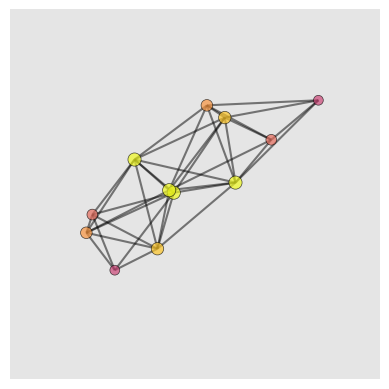

/home/jqma/anaconda3/envs/chirality_index/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    

/home/jqma/anaconda3/envs/chirality_index/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    

/home/jqma/anaconda3/envs/chirality_index/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning:


    Your

path l done
(0.7751882768770237,)


In [173]:
cx1, Gw_l, path_l_w_sum_mean = GT_chirality(xyz_l, thre=1, al=7)  
print(cx1)

In [175]:
twedge_vec_l, twnode_vec_l, twcenter_node_l, twcenter_l, twpos_l = edge_node_vec_torsion(xyz_l, Gw_l, path_l_w_sum_mean)
# twedge_vec_r, twnode_vec_r, twcenter_node_r, twcenter_r, twpos_r = edge_node_vec_torsion(xyz_r, Gw_r, path_r_w_sum_mean)

In [176]:
def G_draw_node(G, ORC, xyz, theta, phi):
    
    
    orc = np.asarray(ORC)

#     norm = colors.Normalize(vmin=-np.max(abs(orc)), vmax=np.max(abs(orc)), clip=True)
    norm = colors.Normalize(vmin=np.min(abs(orc)), vmax=np.max(abs(orc)), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
  
    co = mapper.to_rgba(orc)  

    with plt.style.context(('seaborn-v0_8-white')):
        # fig = plt.figure(figsize=(10,7))
        ax = plt.figure(figsize=(10,7)).add_subplot(projection='3d')
        
        lines = np.append(np.expand_dims(np.array(xyz_l[['x', 'y', 'z']])[np.array(G.edges)[:,0]], axis=1),
                          np.expand_dims(np.array(xyz_l[['x', 'y', 'z']])[np.array(G.edges)[:,1]], axis=1), axis=1)
        
        lc = Line3DCollection(lines, color='gray', alpha=0.5)
        ax.add_collection3d(lc)
        
    
        ax.scatter(xyz_l['x'], xyz_l['y'], xyz_l['z'], c=co, s=100, edgecolors='k', linewidth=1, alpha=0.7)
    
    
        sm = plt.cm.ScalarMappable(cmap=cm.Blues)#, vmin = np.min(orc_sc), vmax = np.max(orc_sc))#, norm=norm)
        sm.set_array([])
        sm.set_clim(vmin=np.min(abs(orc)), vmax=np.max(abs(orc)))
        
    
        ax.set_axis_off()
        ax.view_init(theta, phi)
        plt.show()
        ax.view_init(theta, phi)

In [177]:
def G_draw_edge(G, ORC, xyz, theta, phi):
    
    orc = np.asarray(ORC)


    norm = colors.Normalize(vmin=np.min(abs(orc)), vmax=np.max(abs(orc)), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    co = mapper.to_rgba(orc)

    from mpl_toolkits.mplot3d import Axes3D

    with plt.style.context(('seaborn-v0_8-white')):
        fig = plt.figure(figsize=(20,14))
        ax = Axes3D(fig)
        ax.set_axis_off()
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            # Scatter plot
            scat = ax.scatter(xi, yi, zi, c='lightgray', s=10, edgecolors='k',linewidth=1, alpha=1)
#
        
        e = list(G.edges())
        for jj in range(len(e)):
            x = np.array((pos[e[jj][0]][0], pos[e[jj][1]][0]))
            y = np.array((pos[e[jj][0]][1], pos[e[jj][1]][1]))
            z = np.array((pos[e[jj][0]][2], pos[e[jj][1]][2]))
            # Plot the connecting lines
            ax.plot(x, y, z, c=co[jj], alpha=0.7, linewidth=1)
            
        sm = plt.cm.ScalarMappable(cmap=cm.Blues)
        sm.set_array([])
        # ax.figure.colorbar(sm)

        sm.set_clim(vmin=np.min((orc)), vmax=np.max((orc)))
        
        
        ax.view_init(theta, phi)

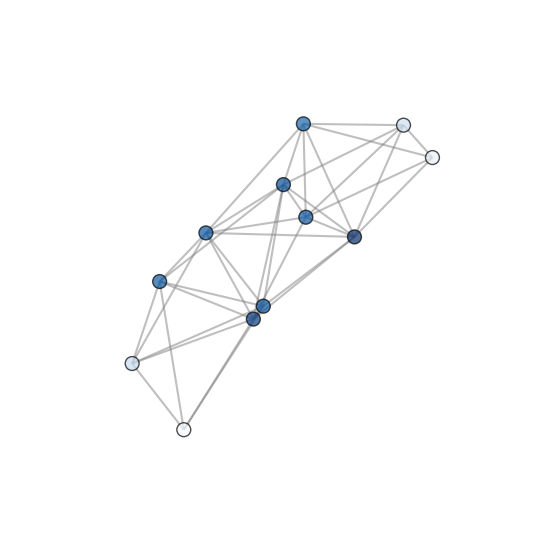

In [178]:
G_draw_node(Gw_l, twnode_vec_l['op_mean'].values.astype('float64'), xyz_l, 90, 90)